In [ ]:
# Much credit to: https://www.kaggle.com/iljara/covid-19-knowledge-graph-a-network-analysis/notebook#COVID-19-literature-network-analysis-using-knowledge-graphs-and-graph_tool


In [1]:
import rdflib
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Import the graph data
# This takes a while...
g = rdflib.Graph()
g.parse('/Users/dnsosa/Downloads/kg.nt', format='nt')

<Graph identifier=Nef485d73e52247f988a84a56fa61adbe (<class 'rdflib.graph.Graph'>)>

In [4]:
# In this kernel the analysis results are interpreted from the perspective of citation networks
# Therefore, it is important to reduce the data only to citation networks.

# Here, they're just reversing the directionality
for p1, _, p2 in g.triples((None, rdflib.URIRef("http://purl.org/spar/cito/isCitedBy"), None)):
    tr = (p2, rdflib.URIRef("http://purl.org/spar/cito/cites"), p1)
    if tr not in g:
        g.add(tr)
    g.remove((p1, rdflib.URIRef("http://purl.org/spar/cito/isCitedBy"), p2))

In [5]:
import urllib
import pandas as pd
from tqdm.notebook import tqdm as ntqdm
metadata = pd.read_csv('/Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/input/cord19/metadata.csv')
dois = metadata['doi'].dropna().apply(lambda x: 'http://dx.doi.org/' + x.strip('doi.org').strip('http://dx.doi.org/')).values
dois = list(set(dois))


papers = []
for doi in ntqdm(dois):
    if len(list(g.triples((rdflib.URIRef(doi), rdflib.URIRef("http://purl.org/spar/cito/cites"), None)))) > 0:
        papers.append(doi)
print(len(papers))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


http://dx.doi.org/10.1002/1097-0142(197106)27:6<1449::aid-cncr2820270627>3.0.co;2-3 does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1002/1521-4141(200002)30:2<347::aid-immu347>3.0.co;2- does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1577/1548-8659(1983)112<247:sdaado>2.0.co;2 does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1002/1521-1878(200103)23:3<251::aid-bies1035>3.0.co;2- does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1002/1096-9071(200103)63:3<259::aid-jmv1010>3.0.co;2- does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1002/1521-396x(200010)181:2<233::aid-pssa233>3.0.co;2-8 does not look like a valid URI, trying to serialize this will break.
http://dx.doi.org/10.1002/1099-1654(200009/10)10:5<291::aid-rmv278>3.0.co;2-u does not look like a valid URI, trying to serialize this


19575


In [102]:
dois = list(set(metadata['doi'].dropna().apply(lambda x: 'http://dx.doi.org/' + x.strip('doi.org').strip('http://dx.doi.org/')).values))

french_doi = 'http://dx.doi.org/10.1101/2020.05.05.20088757' 
french_doi in dois


True

In [104]:
list(g.triples((rdflib.URIRef(french_doi), None, None)))



[]

In [68]:
import igraph as gt

def create_sub_graph_gt(root, depth):
    it = 0
    vnames_inv = {"??INIT??": -1}
    # The vnames array is important! It is used to get the node label (which is a string) 
    # from the node id (which is an integer).
    vnames = {"-1": "??INIT??"}
    
    objects = set()
    
    gt_graph = gt.Graph()
    #gt_graph.set_directed(True)
    
    to_explore = {root}
    for _ in range(depth):
        new_explore = set()
        for node in to_explore:
            for s, p, o in g.triples((node, rdflib.URIRef("http://purl.org/spar/cito/cites"), None)):

                s_name=str(s)
                o_name=str(o)
                
                if s_name != o_name:
                
                    if s_name not in vnames_inv:
                        vnames_inv[s_name] = it
                        vnames[str(it)] = s_name
                        #gt_graph.add_vertex()
                        it=it+1
                    if o_name not in vnames_inv:
                        vnames_inv[o_name] = it
                        vnames[str(it)] = o_name
                        #gt_graph.add_vertex()
                        it=it+1
                
                    #v1 = gt_graph.add_vertices( vnames_inv[s_name] )
                    #v2 = gt_graph.add_vertices( vnames_inv[o_name] )
                    #gt_graph.edge(v1,v2,add_missing=True)
                    
                    if (len(gt_graph.vs) == 0) or (vnames_inv[s_name] not in gt_graph.vs["name"]):
                        v1 = gt_graph.add_vertex(name=vnames_inv[s_name])
                        
                    if (len(gt_graph.vs) == 0) or (vnames_inv[o_name] not in gt_graph.vs["name"]):
                        v2 = gt_graph.add_vertex(name=vnames_inv[o_name])

                    gt_graph.add_edge(v1, v2)
                    
                
                new_explore.add(o)
        to_explore = new_explore
    return gt_graph, vnames, vnames_inv


In [94]:
# Get all the triples that are maximally n_h hops away from our randomly picked paper rand_paper 
##rand_paper = rdflib.URIRef('http://dx.doi.org/10.1186/s12879-015-1251-y')
rand_paper = rdflib.URIRef('http://dx.doi.org/10.1101/2020.05.05.20088757')
n_h = 2
# Generate the network based on the rdflib.Graph()
##gt_graph, vnames, vnames_inv = np.array(create_sub_graph_gt(rand_paper, n_h))
gt_graph, vnames, vnames_inv = np.array(create_sub_graph_gt(rand_paper, n_h))


In [95]:
# If, by any chance, we have parallel edges (i.e. a paper citing the same paper twice) 
# or self-loops (i.e. a paper citing itself), remove them
##gt.remove_parallel_edges(gt_graph)
##gt.remove_self_loops(gt_graph)
gt_graph.simplify()
# Create an array of the node ids (or vertex ids) of the network
v_array=gt_graph.vs
print(v_array)

e_array = gt_graph.es
print(len(e_array))
print(len(v_array))

0
0


In [29]:
for v in v_array:
    print(vnames[str(v['name'])])

http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1371/journal.pone.0018928
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1016/j.jinf.2003.10.006
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1371/journal.pone.0043666
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1007/s100960050400
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1186/1471-2334-12-350
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.3855/jidc.36
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1093/cid/cir043
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.3410/f.717985262.793473388
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1371/journal.pone.0133178
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1111/j.1750-2659.2011.00286.x
http://dx.doi.org/10.1186/s12879-015-1251-y
http://dx.doi.org/10.1093/infdis/jis538
http://dx.doi.org/10.1186/s12879-015-

In [20]:
vnames

{'-1': '??INIT??',
 '0': 'http://dx.doi.org/10.1186/s12879-015-1251-y',
 '1': 'http://dx.doi.org/10.1371/journal.pone.0018928',
 '2': 'http://dx.doi.org/10.1016/j.jinf.2003.10.006',
 '3': 'http://dx.doi.org/10.1371/journal.pone.0043666',
 '4': 'http://dx.doi.org/10.1007/s100960050400',
 '5': 'http://dx.doi.org/10.1186/1471-2334-12-350',
 '6': 'http://dx.doi.org/10.3855/jidc.36',
 '7': 'http://dx.doi.org/10.1093/cid/cir043',
 '8': 'http://dx.doi.org/10.3410/f.717985262.793473388',
 '9': 'http://dx.doi.org/10.1371/journal.pone.0133178',
 '10': 'http://dx.doi.org/10.1111/j.1750-2659.2011.00286.x',
 '11': 'http://dx.doi.org/10.1093/infdis/jis538',
 '12': 'http://dx.doi.org/10.3201/eid1508.081422',
 '13': 'http://dx.doi.org/10.1371/journal.pone.0103293',
 '14': 'http://dx.doi.org/10.21203/rs.2.13231/v1',
 '15': 'http://dx.doi.org/10.1002/jmv.21665',
 '16': 'http://dx.doi.org/10.1542/peds.2013-3042d',
 '17': 'http://dx.doi.org/10.1016/s1473-3099%2801%2900170-0',
 '18': 'http://dx.doi.org/10.

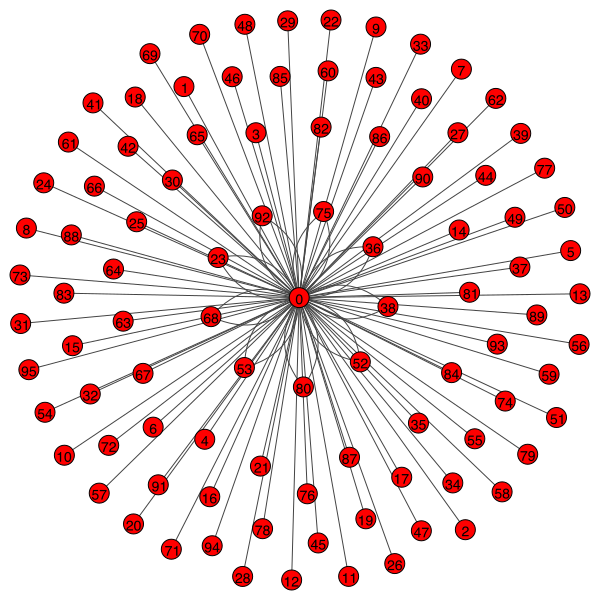

In [70]:
gt_graph.vs["label"] = gt_graph.vs["name"]
gt.plot(gt_graph, layout = gt_graph.layout("fr"))

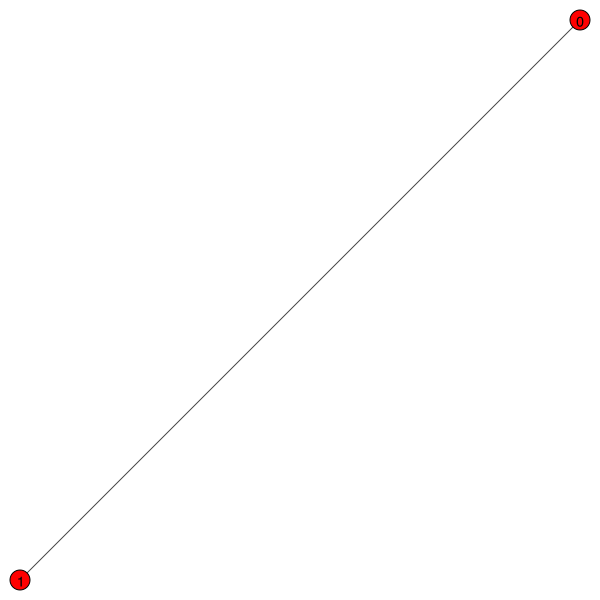

In [44]:
cl = gt_graph.clusters()
lcc = cl.giant()
len(lcc.vs)
len(lcc.es)

6
2


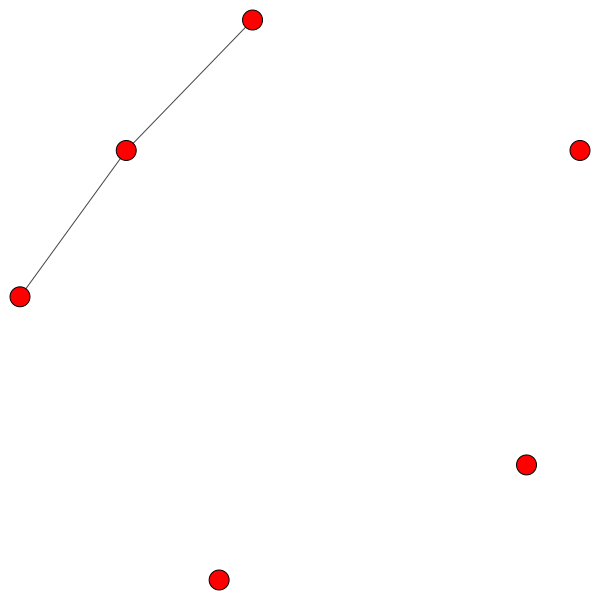

In [56]:

fake_g = gt.Graph()

a = fake_g.add_vertex(name="main")
b = fake_g.add_vertex(name="main")
c = fake_g.add_vertex(name="main")
d = fake_g.add_vertex(name="main")
e = fake_g.add_vertex(name="main")
f = fake_g.add_vertex(name="spain")
fake_g.add_edge(a,f)
fake_g.add_edge(b,f)

print(len(fake_g.vs))
print(len(fake_g.es))

gt.plot(fake_g)

In [61]:
fake_g.vs["name"]

['main', 'main', 'main', 'main', 'main', 'spain']

In [79]:
metadata.dropna().title.str.lower().str.contains("hydroxychloroquine plus azithromycin: a potential interest")

Series([], Name: title, dtype: bool)

In [81]:
metadata[metadata.doi =="10.1101/2020.05.05.20088757"]

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
73279,ktwazcrd,NaN,MedRxiv,Hydroxychloroquine plus azithromycin: a potent...,10.1101/2020.05.05.20088757,NaN,NaN,medrxiv,Introduction: Hydroxychloroquine (HCQ) with or...,2020-05-11,"Davido, B.; Lansaman, T.; Bessis, S.; Lawrence...",NaN,NaN,NaN,NaN,NaN,NaN,http://medrxiv.org/cgi/content/short/2020.05.0...,218580267.0


In [82]:
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,1.14726e+07,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,1.1668e+07,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,1.1668e+07,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,1.16869e+07,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,1.16869e+07,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
(PAPER)-[PAPER_HAS_REFERENCECOLLECTION]->(REFERENCECOLLECTION)-[REFERENCECOLLECTION_HAS_REFERENCE]->(REFERENCE)-[REFERENCE_HAS_PAPERID]->(PAPERID)


